Matheus Barbosa Silva - <strong>11221741</strong>
***
<font size="5"> <strong> EP2 - MAC0209 - Modelagem e Simulação da disseminação da Covid-19 </strong></font>
***

Neste notebook, serão implementadas duas modelagens distintas para o número de casos da Covid-19 construídas por Giorgio Soninno e Armando G. M. Neves, Gustavo Guerrero. A construção e aplicação desses modelos deu-se baseada nos dados das pandemias em regiões diversas (exploram-se os dados de São Paulo, Itália, Luxemburgo, Bélgica e Lombardia) e o cálculo e ajuste dos parâmetros próprios de cada modelo são aspectos discutidos pelos autores em seus respectivos artigos.

Aqui, será usada a sigla G.S. para referir-se à quinta versão do modelo de Giorgio Sonnino (disponível em: https://arxiv.org/pdf/2003.13540v5.pdf), enquanto o modelo dos pesquisadores Armando G. M. Neves e Gustavo Guerrero, será referido por modelo UFMG (instituição dos pesquisadores que publicaram o artigo disponível em: https://arxiv.org/pdf/2005.11182.pdf).

# Preâmbulo

In [2]:
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import os
import numpy as np
import math
from matplotlib import animation, rc
from IPython.display import HTML
import random
import requests
import os
from io import BytesIO
from matplotlib.animation import FuncAnimation,FFMpegFileWriter
import pandas as pd
import random
import matplotlib.ticker as mtick

# Modelagem e Comparação com Dados Reais (modelo G.S.)

Na implementação do modelo de Giorgio Soninno, foram aplicados os mesmos parâmetros abordados pelo autor em seu artigo, a saber:

*   $\alpha$: fator positivo que descreve a taxa de crescimento de novos casos da doença, varia em cada população;
*   $\lambda$: relacionado à taxa de replicação média do vírus, é um parâmetro definido para cada população específica;
*   $\eta$: definido como $\eta = \frac{2A}{t_0}$, onde $A=\frac{K(t)t_0}{2t^2}$, e $K(t)$ é a capacidade de carga estipulada para a população infectada em um certo instante $t$. Os valores desses parâmetros são dados pelo autor para cada região estudada de modo a aprimorar o <i>data fitting</i> (ajuste e precisão da curva) da aproximação;
*   $t_0$: tempo de início das medidas restritivas (como o <i>lockdown</i>), com relação ao dia inicial analisado (dia 0);
*   $N_0$: quantidade inicial de casos da doença no dia 0, no código corresponde ao primeiro valor atribuído à variável N.

O valor de cada parâmetro utilizado nas implmentações a seguir foi extraído dos resultados experimentais do artigo de Giorgio Soninno.

Assim, a partir da equação diferencial ordinária dada no modelo dinâmico  da Covid-19: $\frac{dN}{dt} = \alpha(1-\frac{N}{\eta t^2})N - (\frac{2 \lambda t^2 - 1}{t} - \frac{\lambda t_0 ^2}{t}e^{-\lambda (t-t_0)^2})N$, e aplicando o método de Euler aproximando $dN$ pela diferença finita $N - N_{ant}$, onde $N$ e $N_{ant}$ representam termos subsequentes de uma sequência de aproximações de $N(t)$: $$\frac{N(t)-N_{ant}}{\Delta t} \approx \alpha(1-\frac{N_{ant}}{\eta t^2})N_{ant} - (\frac{2 \lambda t^2 - 1}{t} - \frac{\lambda t_0 ^2}{t}e^{-\lambda (t-t_0)^2})N_{ant} \implies N(t) \approx N_{ant} + \alpha(1-\frac{N_{ant}}{\eta t^2})N_{ant}\Delta t - (\frac{2 \lambda t^2 - 1}{t} - \frac{\lambda t_0 ^2}{t}e^{-\lambda (t-t_0)^2})N_{ant}\Delta t$$

Pode-se variar $\Delta t$ de acordo com a precisão necessária à aproximação. Nos casos a seguir, foram utilizados valores para $\Delta t$ tais que as aproximações geradas pelo método se adequassem aos dados reais com menores erros.

Os dados reais plotados nos gráficos a seguir foram extraídos diretamente da sexta versão do artigo de Giorgio Sonnino. Tais dados foram compilados em arquivos de nome <i>"italia.csv"</i>, <i>"luxemburgo.csv"</i> e <i>"blegica.csv"</i>, contendo a quantidade de casos em cada região mencionada contando a partir de uma certa data fixada como "dia 0" da pandemia na região.

In [3]:
def nextNEuler(nAnt, t, dt, params):
  k = 1 - (nAnt/(params[2]*t*t))
  c = ((2*params[1]*t*t - 1)/t) - ((params[1]*params[3]*params[3]*math.exp(-params[1]*(t-params[3])*(t-params[3])))/t)
  return (nAnt + dt*(params[0]*k*nAnt - c*nAnt))

Cada uma das modelagens a seguir é intepretada como uma "ilha", dado que se desconsideram fatores como a circulação de indivíduos de regiões diversas das analisadas (o que causa uma perturbação dos dados, já que assim haveria linhagens do vírus com diferentes características circulando ao mesmo tempo na região) ou, ainda, mudanças populacionais expressivas (tanto decréscimos quanto acréscimos) no período consideradas. Portanto assume-se, para simplificação do modelo, que os parâmetros citados comportam-se de modo quase constante.

Para a modelagem da pandemia na **Itália**, usa-se: $\alpha = 0.2, \lambda = 0.0014, \eta = 60.5, t_0 = 70.6$ e $N_0 = 2$. Como apresentado no artigo (Figura 10, pg. 12), constrói-se o gráfico para o período compreeendido entre $t=0$ e $t=76$.

A matriz dadosIT contém os dados importados do arquivo italia.csv, sendo este dividido em xDataIT (dia da contagem de casos com relação a um dia 0 estipulado) e yDataIT (cada posição $t$ armazena a quantidade de novos casos manifestados na região durante o dia $t$ da pandemia).

Já os arrays vXeIT e vYeIT guardam a quantidade de dias passados desde o dia 0 da pandemia na região e a estimativa $N(t)$ para a quantidade de novos casos na região durante o dia $t$ da pandemia, respectivamente.

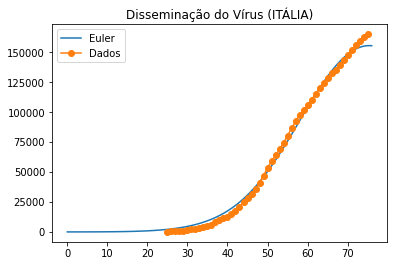

In [19]:
#Plot dos dados da Itália
alpha = 0.2
lmbd = 0.0014
eta = 60.5
t0 = 70.6
N = 2 #2 casos de COVID-19 confirmados na Itália em 31/01 (dia 0)

t = 0
tf = 76
dt = 0.8

paramsIT = [alpha, lmbd, eta, t0]

dadosIT = pd.read_csv("italia.csv")
dadosIT = np.array(dadosIT)

xDataIT = dadosIT[:,0]
yDataIT = dadosIT[:,1]

vYeIT = []
vXeIT = []
while (t < tf):
  vYeIT.append(N)
  vXeIT.append(t)
  t += dt
  N = nextNEuler(N, t, dt, paramsIT);
plt.figure(0)
plt.plot(vXeIT, vYeIT, label='Euler')
plt.plot(xDataIT, yDataIT, label='Dados', marker='o')
plt.title('Disseminação do Vírus (ITÁLIA)')
plt.legend()
plt.show(block=False)

Para a modelagem da pandemia na **Bélgica**, usa-se: $\alpha = 0.24, \lambda = 0.0025, \eta = 29.5, t_0 = 48.8$ e $N_0 = 1$. Como apresentado no artigo (Figura 11, pg. 13), constrói-se o gráfico para o período compreeendido entre $t=0$ e $t=55$.

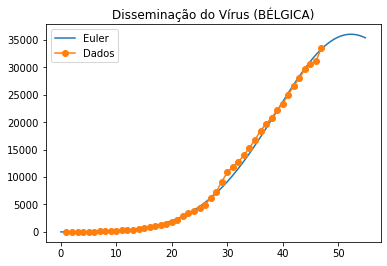

In [8]:
#Plot dos dados da Bélgica
alpha = 0.24
lmbd = 0.0025
eta = 29.5
t0 = 48.8
N = 1

t = 0
tf = 55
dt = 0.3

paramsBE = [alpha, lmbd, eta, t0]

dadosBE = pd.read_csv("belgica.csv")
dadosBE = np.array(dadosBE)

xDataBE = dadosBE[:,0]
yDataBE = dadosBE[:,1]

vYeBE = []
vXeBE = []
while (t < tf):
  vYeBE.append(N)
  vXeBE.append(t)
  t += dt
  N = nextNEuler(N, t, dt, paramsBE);
plt.figure(1)
plt.plot(vXeBE, vYeBE, label='Euler')
plt.plot(xDataBE, yDataBE, label='Dados', marker='o')
plt.legend()
plt.title('Disseminação do Vírus (BÉLGICA)')
plt.show(block=False)

Para a modelagem da pandemia em **Luxemburgo**, usa-se: $\alpha = 0.33, \lambda = 0.0043, \eta = 4.3, t_0 = 38.5$ e $N_0 = 1$. Como apresentado no artigo (Figura 18, pg. 20), constrói-se o gráfico para o período compreeendido entre $t=0$ e $t=44$.

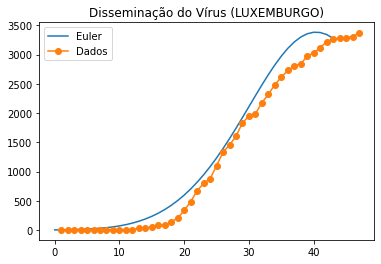

In [6]:
#Plot dos dados de Luxemburgo
alpha = 0.33
lmbd = 0.0043
eta = 4.3
t0 = 38.5
N = 1

t = 0
tf = 44
dt = 1

paramsLX = [alpha, lmbd, eta, t0]

dadosLX = pd.read_csv("luxemburgo.csv")
dadosLX = np.array(dadosLX)

xDataLX = dadosLX[:,0]
yDataLX = dadosLX[:,1]

vYeLX = []
vXeLX = []
while (t < tf):
  vYeLX.append(N)
  vXeLX.append(t)
  t += dt
  N = nextNEuler(N, t, dt, paramsLX);
plt.figure(1)
plt.plot(vXeLX, vYeLX, label='Euler')
plt.plot(xDataLX, yDataLX, label='Dados', marker='o')
plt.title('Disseminação do Vírus (LUXEMBURGO)')
plt.legend()
plt.show(block=False)

# Animações (modelo G.S.)

Para cada uma das animações, foi utilizada uma janela fixa para descrever o avanço da quantidade de casos de Covid-19 em cada região, onde a cruva desenhada corresponde ao gráfico da função $N(t)$. Também gera-se, para cada animação, um **vídeo em formato mp4** contendo a trajetória completa da curva.

As funções seguintes são responsáveis pela criação da animação e, a cada instante $i$ da animação, por meio da função animate(i), insere-se na variável line (que tem seu conteúdo acessado e plotado na animação a cada instante) todas as coordenadas calculadas anteriormente correspondentes a $N(0),...,N(i)$.

In [ ]:
def initAnimate():
  line.set_data([], [])
  return (line,)

def animate(i):    
    line.set_data(xAnim[0:i], yAnim[0:i])
    return (line,)

def createAnimPlot(xAnim, title, xLim, yLim):
    plt.close()

    figAnim, axAnim = plt.subplots(1, 1, figsize = (6, 6))
    axAnim.set_title(title)
    axAnim.set_xlim([0, xLim])
    axAnim.set_ylim([0, yLim])
    
    line, = axAnim.plot([], [], 'k', lw=3, linestyle='-', animated=True)
    nFrames = len(xAnim) - 1
    
    return(figAnim, axAnim, nFrames, line)

O seguinte bloco é responsável por acionar as funções para a animação criadas anteriormente usando os dados da Itália (arrays vXeIT e vYeIT), ajustando a janela da animação para $x \in [0, 80]$ e $y \in [0, 200000]$.

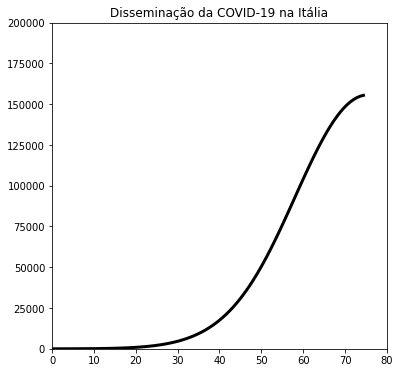

In [ ]:
#ANIMAÇÃO PARA A ITÁLIA
xAnim = vXeIT
yAnim = vYeIT

figAnim, axAnim, nFrames, line, = createAnimPlot(xAnim, "Disseminação da COVID-19 na Itália", 80, 200000)

anim = animation.FuncAnimation(figAnim, animate, init_func=initAnimate,
                            frames=nFrames, interval=2.5, blit=True)

mywriter = FFMpegFileWriter(fps=25,codec="libx264")
anim.save("Italia.mp4", writer=mywriter)

rc('animation', html='jshtml')
anim

O seguinte bloco é responsável por acionar as funções para a animação criadas anteriormente usando os dados da Bélgica (arrays vXeBE e vYeBE), ajustando a janela da animação para $x \in [0, 60]$ e $y \in [0, 40000]$.

In [ ]:
#ANIMAÇÃO PARA A BÉLGICA
xAnim = vXeBE
yAnim = vYeBE

figAnim, axAnim, nFrames, line, = createAnimPlot(xAnim, "Disseminação da COVID-19 na Bélgica", 60, 40000)

anim = animation.FuncAnimation(figAnim, animate, init_func=initAnimate,
                            frames=nFrames, interval=2.5, blit=True)

mywriter = FFMpegFileWriter(fps=25,codec="libx264")
anim.save("Belgica.mp4", writer=mywriter)

rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

O seguinte bloco é responsável por acionar as funções para a animação criadas anteriormente usando os dados de Luxemburgo (arrays vXeLX e vYeLX), ajustando a janela da animação para $x \in [0, 60]$ e $y \in [0, 4000]$.

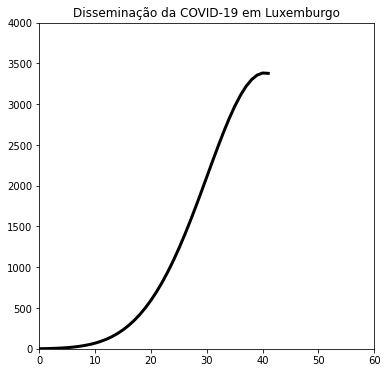

In [ ]:
#ANIMAÇÃO PARA LUXEMBURGO
xAnim = vXeLX
yAnim = vYeLX

figAnim, axAnim, nFrames, line, = createAnimPlot(xAnim, "Disseminação da COVID-19 em Luxemburgo", 60, 4000)

anim = animation.FuncAnimation(figAnim, animate, init_func=initAnimate,
                            frames=nFrames, interval=2.5, blit=True)

mywriter = FFMpegFileWriter(fps=25,codec="libx264")
anim.save("Luxemburgo.mp4", writer=mywriter)

rc('animation', html='jshtml')
anim

# Modelagem de Múltiplas ilhas (modelo G.S.)

No bloco seguinte, preenche-se a matriz de parâmetros (conjParams) com os valores gerados aleatoriamente para cada um dos parâmetros usando uma distribuição triangular. Cada coluna da matriz corresponde a um parâmetro, sendo estes: $\alpha, \lambda, t_0$ e $\eta$ (sendo este último obitdo do valor gerado aleatoriamente para $A$ usando a relação $\eta = \frac{2A}{t_0}$).

A quantidade inicial de casos ($N_0$) é, também gerada aleatoriamente (sem o uso de alguma distribuição específica), e seu valor é compartilhado entre todas as ilhas. Desta forma, é possível observar a interferência de cada parâmetro na dinâmica da pandemia. 

Optou-se por gerar os valores aleatoriamente seguindo uma distribuição triangular em torno dos valores dados e observados para assegurar que os cenários descritos pelas ilhas aleatórias seriam razoáveis, mas ainda abrangentes.

In [ ]:
conjParams = np.zeros((5, 4))

for i in range(0, 5):
  conjParams[i][0] = random.triangular(0, 1) #alpha

for i in range(0, 5):
  conjParams[i][1] = random.triangular(0, 0.01) #lambda

for i in range(0, 5):
  conjParams[i][3] = random.triangular(1, 100) #t0

for i in range(0, 5):
  conjParams[i][2] = 2*random.triangular(0, 3000)/conjParams[i][3] #eta

N = random.randint(1, 30)

print('N0 = ', N)
print("N0: \u03B1 = ", conjParams[0][0], ", \u03BB = ", conjParams[0][1], ", t0 = ", conjParams[0][2], ", \u03B7 = ", conjParams[0][3])
print("N1: \u03B1 = ", conjParams[1][0], ", \u03BB = ", conjParams[1][1], ", t0 = ", conjParams[1][2], ", \u03B7 = ", conjParams[1][3])
print("N2: \u03B1 = ", conjParams[2][0], ", \u03BB = ", conjParams[2][1], ", t0 = ", conjParams[2][2], ", \u03B7 = ", conjParams[2][3])
print("N3: \u03B1 = ", conjParams[3][0], ", \u03BB = ", conjParams[3][1], ", t0 = ", conjParams[3][2], ", \u03B7 = ", conjParams[3][3])
print("N4: \u03B1 = ", conjParams[4][0], ", \u03BB = ", conjParams[4][1], ", t0 = ", conjParams[4][2], ", \u03B7 = ", conjParams[4][3])

N0 =  1
N0: α =  0.2962461449191048 , λ =  0.005742335435989452 , t0 =  127.41211738087667 , η =  29.46169757024791
N1: α =  0.6575002789095229 , λ =  0.009614307749741187 , t0 =  53.718358690876606 , η =  84.54113905544709
N2: α =  0.5782407819818888 , λ =  0.008056517285886397 , t0 =  172.02288320238117 , η =  21.29934676934928
N3: α =  0.5668345448030154 , λ =  0.004373980094853593 , t0 =  71.50949957485422 , η =  49.256047538796004
N4: α =  0.40278986831036745 , λ =  0.004067218911699366 , t0 =  126.36838100869547 , η =  36.679022260403485


Então, aplica-se a modelagem anterior para cada uma das cinco ilhas com parâmetros criados aleatoriamente (da mesma forma feita para cada uma das ilhas nos casos anteriores), gerando os 5 primeiros gráficos.

O último gráfico, em três dimensões, é o resultado dos produtos cartesianos entre cada dupla $N_i(t)$ em função do tempo $t$. Desta forma, é possível analisar o avanço conjunto da doença em cada dupla de ilhas. 

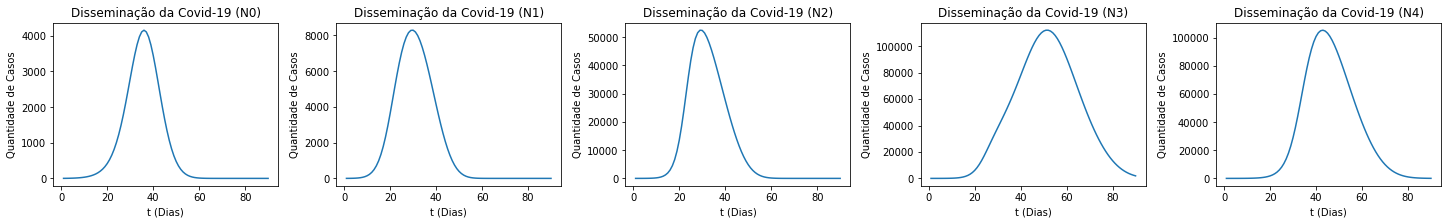

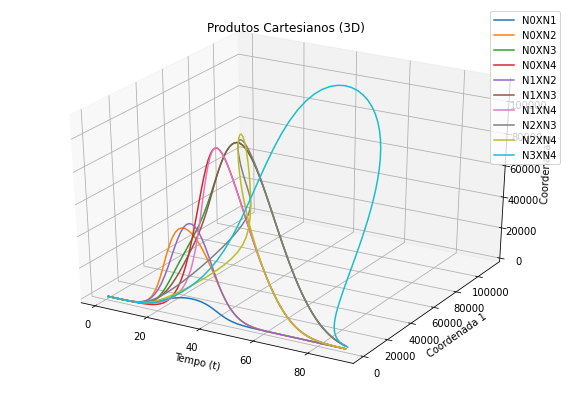

In [ ]:
N0 = N1 = N2 = N3 = N4 = N
vYeN0 = []
vYeN1 = []
vYeN2 = []
vYeN3 = []
vYeN4 = []
normV = []
vT = np.arange(1, 91, 1)
t = 1
tf = 91
dt = 1

while (t < tf):
  vYeN0.append(N0)
  vYeN1.append(N1)
  vYeN2.append(N2)
  vYeN3.append(N3)
  vYeN4.append(N4)
  v = [N0, N1, N2, N3, N4]
  normV.append(np.linalg.norm(v));
  t += dt
  N0 = nextNEuler(N0, t, dt, conjParams[0]);
  N1 = nextNEuler(N1, t, dt, conjParams[1]);
  N2 = nextNEuler(N2, t, dt, conjParams[2]);
  N3 = nextNEuler(N3, t, dt, conjParams[3]);
  N4 = nextNEuler(N4, t, dt, conjParams[4]);

fig, ax = plt.subplots(1, 5,figsize=(20,3), constrained_layout=True)

ax[0].plot(vT, vYeN0, label='Euler')
ax[0].set_title('Disseminação da Covid-19 (N0)')
ax[0].set(xlabel='t (Dias)', ylabel='Quantidade de Casos')

ax[1].plot(vT, vYeN1, label='Euler')
ax[1].set_title('Disseminação da Covid-19 (N1)')
ax[1].set(xlabel='t (Dias)', ylabel='Quantidade de Casos')

ax[2].plot(vT, vYeN2, label='Euler')
ax[2].set_title('Disseminação da Covid-19 (N2)')
ax[2].set(xlabel='t (Dias)', ylabel='Quantidade de Casos')

ax[3].plot(vT, vYeN3, label='Euler')
ax[3].set_title('Disseminação da Covid-19 (N3)')
ax[3].set(xlabel='t (Dias)', ylabel='Quantidade de Casos')

ax[4].plot(vT, vYeN4, label='Euler')
ax[4].set_title('Disseminação da Covid-19 (N4)')
ax[4].set(xlabel='t (Dias)', ylabel='Quantidade de Casos')

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.plot3D(vT, vYeN0, vYeN1, label='N0XN1')
ax.plot3D(vT, vYeN0, vYeN2, label='N0XN2')
ax.plot3D(vT, vYeN0, vYeN3, label='N0XN3')
ax.plot3D(vT, vYeN0, vYeN4, label='N0XN4')
ax.plot3D(vT, vYeN1, vYeN2, label='N1XN2')
ax.plot3D(vT, vYeN1, vYeN3, label='N1XN3')
ax.plot3D(vT, vYeN1, vYeN4, label='N1XN4')
ax.plot3D(vT, vYeN2, vYeN3, label='N2XN3')
ax.plot3D(vT, vYeN2, vYeN4, label='N2XN4')
ax.plot3D(vT, vYeN3, vYeN4, label='N3XN4')
ax.set_xlabel('Tempo (t)')
ax.set_ylabel('Coordenada 1')
ax.set_zlabel('Coordenada 2')
plt.title('Produtos Cartesianos (3D)')
plt.legend()
plt.show(block=False)

Geração de vídeo em formato mp4 com a rotação do gráfico anterior em 3 dimensões para sua melhor visualização. A rotação é controlada pelo parâmetro azim na função view_init e está associado ao instante da animação (realiza-se uma rotação de 4° a cada frame de modo que em 90 frames, seja possível realizar a rotação completa de 360°).

In [ ]:
def init():
    return fig,

def animate(i):
    ax.view_init(elev=10, azim=i*4)
    return fig,

animRotate = animation.FuncAnimation(fig, animate, init_func=init, frames=90, interval=50, blit=True)
animRotate
animRotate.save('graficoPC.mp4',writer=mywriter)


Para plotar $|v|$ a cada instante $t$, usa-se a função **np.linalg.norm(v)**, reunindo os resultados dessa operação a cada tempo $t$ e, em seguida, plotando o array normV no eixo $y$ do segundo gráfico.

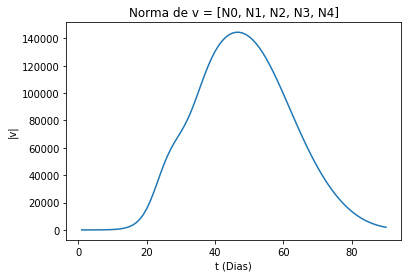

In [ ]:
plt.figure()
plt.plot(vT, normV, label='Euler')
plt.title('Norma de v = [N0, N1, N2, N3, N4]')
plt.ylabel('|v|')
plt.xlabel('t (Dias)')
plt.show(block=False)

# Simulação de Múltiplas ilhas (modelo G.S.)

Aqui se optou por exibir a animação com eixos que se ajustam de forma dinâmica aos dados, permitindo assim uma visualização mais detalhada de cada um dos gráficos a cada instante de tempo. Esse processo de auto-escala dos eixos é feito pelos comandos axAnim.relim() e axAnim.autoscale_view().

Todo o processo de criação da animação é feito de forma análoga à anterior, usando agora cinco variáveis line - cada uma representa a curva de uma das ilhas.

In [ ]:
def initAnimateIlhas():
  line0.set_data([], [])
  line1.set_data([], [])
  line2.set_data([], [])
  line3.set_data([], [])
  line4.set_data([], [])
  return (line0, line1, line2, line3, line4,)

def animateIlhas(i):    
    line0.set_data(vT[0:i], vYeN0[0:i])
    line1.set_data(vT[0:i], vYeN1[0:i])
    line2.set_data(vT[0:i], vYeN2[0:i])
    line3.set_data(vT[0:i], vYeN3[0:i])
    line4.set_data(vT[0:i], vYeN4[0:i])
    axAnim.relim()
    axAnim.autoscale_view()
    return (line0, line1, line2, line3, line4,)

def createAnimPlotIlhas():
    plt.close()

    figAnim, axAnim = plt.subplots(1, 1, figsize = (6, 6))
    axAnim.set_title('Evolução da COVID-19 nas ilhas')
    axAnim.relim()
    axAnim.autoscale_view()
    
    line0, = axAnim.plot([], [], 'k', lw=3, linestyle='-', marker='o', animated=True)
    line1, = axAnim.plot([], [], 'r', lw=3, linestyle='-', marker='v', animated=True)
    line2, = axAnim.plot([], [], 'g', lw=3, linestyle='-', marker='s', animated=True)
    line3, = axAnim.plot([], [], 'b', lw=3, linestyle='-', marker='*', animated=True)
    line4, = axAnim.plot([], [], 'y', lw=3, linestyle='-', marker='x', animated=True)
    nFrames = len(vT) - 1
    
    return(figAnim, axAnim, nFrames, line0 ,line1, line2, line3, line4,)

figAnim, axAnim, nFrames, line0, line1, line2, line3, line4, = createAnimPlotIlhas()

anim = animation.FuncAnimation(figAnim, animateIlhas, init_func=initAnimateIlhas,
                            frames=nFrames, interval=2.5, blit=True)

rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

# Modelagem da Disseminação da Covid-19 em São Paulo (modelo UFMG)

Para calcular os valores para $A(t), S(t), I(t), R_s(t)$ e $D(t)$, foram usadas funções distintas para os casos em que há a aplicação de medidas de contenção ou não - assim, é possível conduzir um estudo da efetividade dessas medidas e, ainda, projetar seus efeitos a longo prazo. Para cada uma das estatísticas:


*   $A(t)$: indivíduos afetados pela doença no instante $t$, porém assintomáticos. São os responsáveis pela transmissão do vírus por maiores períodos de tempo. Por Euler: $A(t)=A_{ant} + \Delta t\beta_0(1- \xi)(I_{ant} + \mu A_{ant})S_{ant} - \Delta t \gamma_a A$.
*   $S(t)$: indivíduos suscetíveis à infecção no instante $t$. No início da pandemia ($t=0$), assume-se que 100% da população pertence a esse grupo. Por Euler: $S(t)=S_{ant} - \Delta t\beta_0(I_{ant} + \mu A_{ant})S_{ant}$.
*   $I(t)$: indivíduos infectados pelo vírus e sintomáticos (geralmente transmitem a doença por menos tempo, dado que são, usualmente, hospitalizados).  Por Euler: $I(t)=I_{ant} + \Delta t\beta_0 \xi(I_{ant} + \mu A_{ant})S_{ant} - \Delta t \gamma_s I_{ant}$.
*   $R_s(t)$: são os removidos sintomáticos (número acumulado) no instante $t$. O conceito de remoção do sistema compreeende mortes e curas, são todos aqueles que apresentavam sintomas e deixaram de transmitir a doença. Por Euler: $R_s(t) = R_{sAnt} + \Delta t \gamma_s I_{ant}$.
*   $D(t)$: quantidade acumulada de mortes na região, representa uma fração dos removidos sintomáticos. Por definição: $D(t)=\omega R_s(t)$, onde $\omega$ é um parâmetro relacionado à fatalidade dos casos em uma região.

Os parâmetros e equações que descrevem cada um dos grupos são abordadas no relatório. Vale ressaltar que todos esses grupos são medidos e expressos em percentual com relação à população total da região.

In [ ]:
def nextSeuler(params, sAnt, iAnt, aAnt, dt):
  return (sAnt-dt*params[5]*sAnt*(iAnt + params[2]*aAnt))

def nextIeuler(params, sAnt, iAnt, aAnt, dt):
  return (iAnt+dt*params[5]*params[4]*sAnt*(iAnt + params[2]*aAnt) - dt*params[0]*iAnt)

def nextAeuler(params, sAnt, iAnt, aAnt, dt):
  return (aAnt+dt*params[5]*(1-params[4])*sAnt*(iAnt + params[2]*aAnt) - dt*params[1]*aAnt)

def nextReuler(params, iAnt, rAnt, dt):
  return (rAnt + dt*iAnt*params[0])

def nextSeulerLockd(params, sAnt, iAnt, aAnt, dt, beta):
  return (sAnt-dt*beta*sAnt*(iAnt + params[2]*aAnt))

def nextIeulerLockd(params, sAnt, iAnt, aAnt, dt, beta):
  return (iAnt+dt*beta*params[4]*sAnt*(iAnt + params[2]*aAnt) - dt*params[0]*iAnt)

def nextAeulerLockd(params, sAnt, iAnt, aAnt, dt, beta):
  return (aAnt+dt*beta*(1-params[4])*sAnt*(iAnt + params[2]*aAnt) - dt*params[1]*aAnt)

Note que este modelo demanda de uma maior quantidade de parâmetros, mas em contrapartida, produz mais dados para a previsão da disseminação da doença nos próximos dias e, até, assintoticamente (como demonstrado pelo parâmetro $\rho$)

Foram utilizados valores aleatórios para $\epsilon_1 \in [0,1]$ e $\xi$, a intensidade das medidas de contenção do vírus aplicadas na região e a probabilidade de que uma infecção desenvolva um caso sintomático da doença, respectivamente. Assim, é possível observar e planejar diversos cenários para a região de acordo com a intensidade das medidas restritivas e de características próprias do desenvolvimento do vírus em São Paulo.

No bloco a seguir, atribuem-se aos demais parâmetros do modelo os valores identificados pelos escritores do artigo: $\gamma_s= 1/7, \gamma_a = 1/21, \mu = 0.5, \lambda_+ = 0.302, \omega = 0.074$. 

In [ ]:
gamS = 1/7
gamA = 1/21
mu = 0.5
lmbdP = 0.302
eps1 = random.triangular(0,1)
csi = random.triangular(0,1)
while (csi == 0):
  csi = random.triangular(0,1)
print('csi = ', csi)
w = 0.074

beta0 = ((lmbdP + gamS)*(lmbdP + gamA))/((lmbdP + gamS)*csi + mu*(1-csi)*(lmbdP + gamA))
beta = beta0*(1-(1-eps1)*((1+math.erf(-14))/2))

rho = 1 - ((beta0*(1-csi))/(lmbdP + gamA + beta0*(1-csi)*(1-mu))) #altura do plateau (aproximadamente) em Rs
t = 0
tf = 150
dt = 1

print('Intensidade do lockdown: ', eps1)

csi =  0.582423471234998
Intensidade do lockdown:  0.4998629550677202


No bloco seguinte, usam-se as regras e parâmetros definidos anteriormente para construir a dinâmica do modelo A-SIR e plotar cada uma das curvas no plano. As funções e parâmetros referentes ao cálculo das estatísticas $A, S, I, R_s$ e $D$ com a aplicação de medidas de contenção são evidenciados no código por meio do uso do sufixo "lockd".

Os dois gráficos na região inferior referem-se à expressão $\frac{I(t)}{I(t)+A(t)}$ definida pelos autores e que permite mensurar a expressividade dos casos sintomáticos registrados entre o total de casos na região (isto é, qual a parcela das infecções é efetivamente reconhecida pelo Estado).

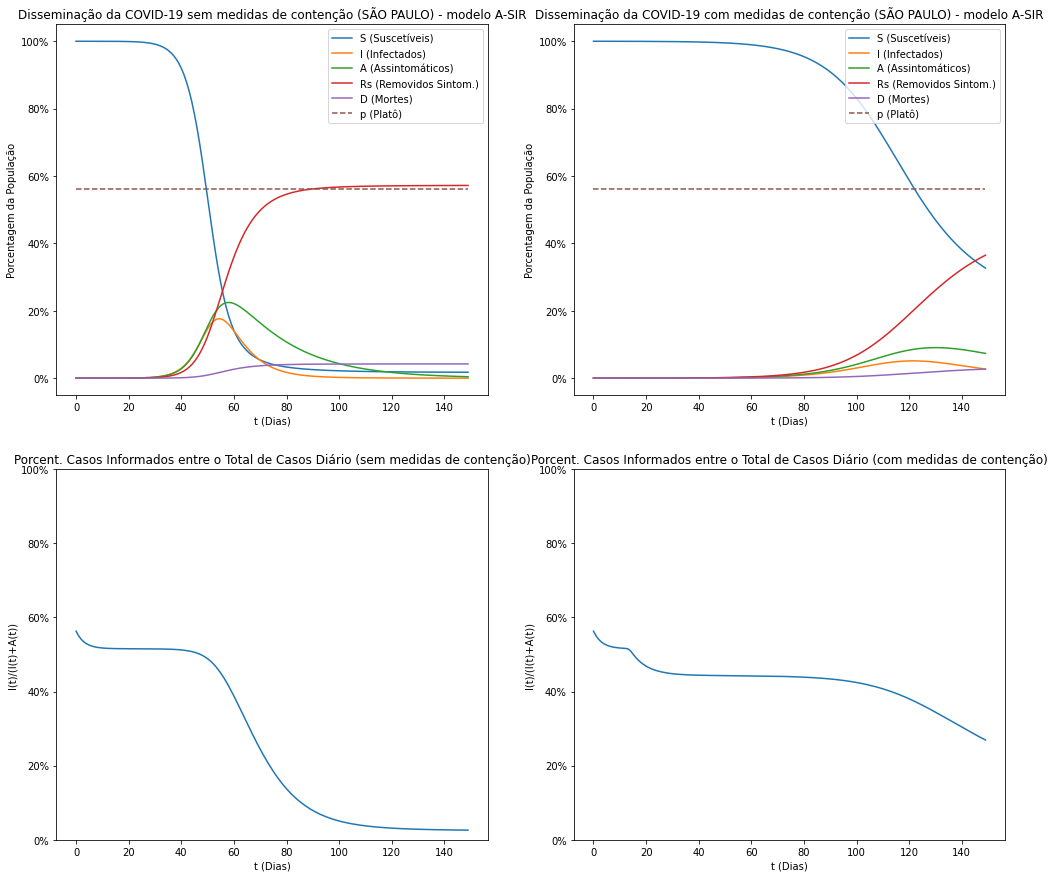

In [ ]:
paramsASIR = [gamS, gamA, mu, lmbdP, csi, beta0]
vSeSP = []
vIeSP = []
vAeSP = []
vYCompSP = []
vXeSP = []
vReSP = []
vDeSP = []

vSeSPlockd = []
vIeSPlockd = []
vAeSPlockd = []
vReSPlockd = []
vDeSPlockd = []
vYCompSPlockd = []

S = Slockd = 1
I = Ilockd = 0.00000356522
A = Alockd = I*(1 - rho)/rho
Rs = Rslockd = (2.17391*10**(-8))/w
D = Dlockd = 0
vYrho = np.ones(tf - t)*rho

while (t < tf):
  vSeSP.append(S)
  vSeSPlockd.append(Slockd)
  vIeSP.append(I)
  vIeSPlockd.append(Ilockd)
  vAeSP.append(A)
  vAeSPlockd.append(Alockd)
  vReSP.append(Rs)
  vReSPlockd.append(Rslockd)
  vDeSP.append(D)
  vDeSPlockd.append(Dlockd)
  vYCompSP.append((I/(I+A)))
  vYCompSPlockd.append((Ilockd/(Ilockd+Alockd)))
  vXeSP.append(t)
  t += dt
  beta = beta0*(1-(1-eps1)*((1+math.erf(t-14))/2))

  nextS = nextSeuler(paramsASIR, S, I, A, dt)
  Rs = nextReuler(paramsASIR, I, Rs, dt)
  nextI = nextIeuler(paramsASIR, S, I, A, dt)
  nextA = nextAeuler(paramsASIR, S, I, A, dt)
  D = w*Rs
  S = nextS
  I = nextI
  A = nextA

  nextSlockd = nextSeulerLockd(paramsASIR, Slockd, Ilockd, Alockd, dt, beta)
  Rslockd = nextReuler(paramsASIR, Ilockd, Rslockd, dt)
  nextIlockd = nextIeulerLockd(paramsASIR, Slockd, Ilockd, Alockd, dt, beta)
  nextAlockd = nextAeulerLockd(paramsASIR, Slockd, Ilockd, Alockd, dt, beta)
  Dlockd = w*Rslockd
  Slockd = nextSlockd
  Ilockd = nextIlockd
  Alockd = nextAlockd

fig, ax = plt.subplots(2,2,figsize=(17,15))

#Plot do gráfico para SP sem medidas de contenção
ax[0][0].plot(vXeSP, vSeSP, label='S (Suscetíveis)')
ax[0][0].plot(vXeSP, vIeSP, label='I (Infectados)')
ax[0][0].plot(vXeSP, vAeSP, label='A (Assintomáticos)')
ax[0][0].plot(vXeSP, vReSP, label='Rs (Removidos Sintom.)')
ax[0][0].plot(vXeSP, vDeSP, label='D (Mortes)')
ax[0][0].plot(vXeSP, vYrho, linestyle='--', label = 'p (Platô)')
ax[0][0].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[0][0].get_yticks()]) 
ax[0][0].set_title('Disseminação da COVID-19 sem medidas de contenção (SÃO PAULO) - modelo A-SIR')
ax[0][0].legend()
ax[0][0].set(ylabel='Porcentagem da População', xlabel='t (Dias)')

#Expressividade dos casos registrados entre o total de casos (sem medidas de contenção)
ax[1][0].plot(vXeSP, vYCompSP)
ax[1][0].set_ylim((0,1))
ax[1][0].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[1][0].get_yticks()]) 
ax[1][0].set_title('Porcent. Casos Informados entre o Total de Casos Diário (sem medidas de contenção)')
ax[1][0].set(ylabel='I(t)/(I(t)+A(t))', xlabel='t (Dias)')

#Plot do gráfico para SP com medidas de contenção
ax[0][1].plot(vXeSP, vSeSPlockd, label='S (Suscetíveis)')
ax[0][1].plot(vXeSP, vIeSPlockd, label='I (Infectados)')
ax[0][1].plot(vXeSP, vAeSPlockd, label='A (Assintomáticos)')
ax[0][1].plot(vXeSP, vReSPlockd, label='Rs (Removidos Sintom.)')
ax[0][1].plot(vXeSP, vDeSPlockd, label='D (Mortes)')
ax[0][1].plot(vXeSP, vYrho, linestyle='--', label = 'p (Platô)')
ax[0][1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[0][1].get_yticks()]) 
ax[0][1].set_title('Disseminação da COVID-19 com medidas de contenção (SÃO PAULO) - modelo A-SIR')
ax[0][1].legend()
ax[0][1].set(ylabel='Porcentagem da População', xlabel='t (Dias)')

#Expressividade dos casos registrados entre o total de casos (com medidas de contenção)
ax[1][1].plot(vXeSP, vYCompSPlockd)
ax[1][1].set_ylim((0,1))
ax[1][1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[1][1].get_yticks()]) 
ax[1][1].set_title('Porcent. Casos Informados entre o Total de Casos Diário (com medidas de contenção)')
ax[1][1].set(ylabel='I(t)/(I(t)+A(t))', xlabel='t (Dias)')

plt.show(block=False)